### 1. Download dataset

In [49]:
PROJECT_PATH = "/Users/shawn/Documents/personal/rsi_divergence_detector"
import os
import sys
import pandas as pd
sys.path.append(f"{PROJECT_PATH}")

df = pd.read_csv(f"{PROJECT_PATH}/data/training_data.csv")
df.head(3)

,datetime,timestamp,open,high,low,close,volume,timeframe,rsi,macd,...,future_return_zscore_56,label_56,future_return_zscore_57,label_57,future_return_zscore_58,label_58,future_return_zscore_59,label_59,future_return_zscore_60,label_60
0,2017-08-17 04:33:00,1502944380000,4267.99,4267.99,4267.99,4267.99,4.127747,1m,51.955604,2.372638,...,1.314182,1,1.302888,1,1.291869,1,1.281113,1,1.270671,1
1,2017-08-17 04:34:00,1502944440000,4296.63,4296.63,4296.63,4296.63,0.952506,1m,71.973819,4.405165,...,0.580533,1,0.575438,1,0.570466,1,0.565612,1,0.560899,1
2,2017-08-17 04:35:00,1502944500000,4300.38,4300.38,4300.38,4300.38,1.038218,1m,73.529050,6.246546,...,0.485195,0,0.480906,0,0.476720,0,0.472633,0,0.468665,0


In [50]:
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce', infer_datetime_format=True)
df['datetime'] = df['datetime'].apply(lambda x: x.replace(hour=0, minute=0, second=0) if pd.notnull(x) and x.time() == pd.Timestamp.min.time() else x)

if df.index.dtype == 'int64':
    df.set_index('datetime', inplace=True)
df.head(3)


/var/folders/ns/shg9ht0545sbbr41sk4q_zgr0000gn/T/ipykernel_35141/1734794695.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce', infer_datetime_format=True)


,timestamp,open,high,low,close,volume,timeframe,rsi,macd,macd_signal,...,future_return_zscore_56,label_56,future_return_zscore_57,label_57,future_return_zscore_58,label_58,future_return_zscore_59,label_59,future_return_zscore_60,label_60
datetime,,,,,,,,,,,,,,,,,,,,,
2017-08-17 04:33:00,1502944380000,4267.99,4267.99,4267.99,4267.99,4.127747,1m,51.955604,2.372638,1.497453,...,1.314182,1,1.302888,1,1.291869,1,1.281113,1,1.270671,1
2017-08-17 04:34:00,1502944440000,4296.63,4296.63,4296.63,4296.63,0.952506,1m,71.973819,4.405165,2.078996,...,0.580533,1,0.575438,1,0.570466,1,0.565612,1,0.560899,1
2017-08-17 04:35:00,1502944500000,4300.38,4300.38,4300.38,4300.38,1.038218,1m,73.529050,6.246546,2.912506,...,0.485195,0,0.480906,0,0.476720,0,0.472633,0,0.468665,0


In [52]:
data_by_time = {}
for timeframe in df.timeframe.unique():
    data_by_time[timeframe] = df[df.timeframe == timeframe]


### 2. Feature Engineering

#### 2-1. 15min data

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [53]:
df_15 = data_by_time['15m']
df_15.head(3)

,timestamp,open,high,low,close,volume,timeframe,rsi,macd,macd_signal,...,future_return_zscore_56,label_56,future_return_zscore_57,label_57,future_return_zscore_58,label_58,future_return_zscore_59,label_59,future_return_zscore_60,label_60
datetime,,,,,,,,,,,,,,,,,,,,,
2017-08-17 12:15:00,1502972100000,4441.87,4441.87,4418.12,4418.12,9.921389,15m,55.669550,38.553087,42.856545,...,-1.160275,-1,-1.349549,-1,-1.222834,-1,-0.892135,-1,-1.379187,-1
2017-08-17 12:30:00,1502973000000,4417.00,4431.13,4411.01,4431.13,1.089877,15m,57.593369,35.966695,41.478575,...,-1.461453,-1,-1.332796,-1,-0.998939,-1,-1.487811,-1,-1.220884,-1
2017-08-17 12:45:00,1502973900000,4430.00,4431.13,4411.00,4411.00,0.846974,15m,53.709502,31.924631,39.567786,...,-1.188893,-1,-0.851731,-1,-1.348460,-1,-1.079159,-1,-0.957549,-1


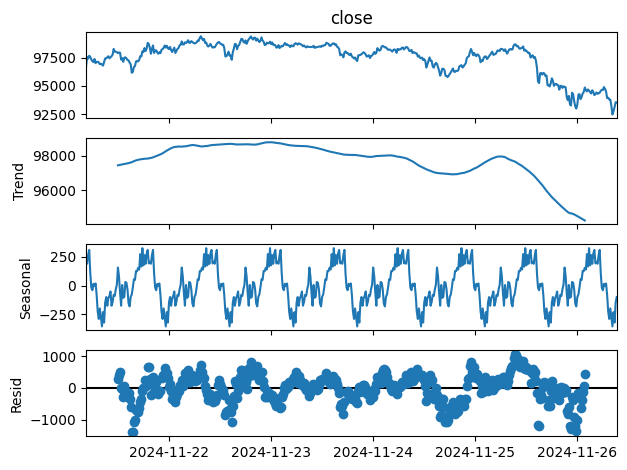

In [61]:
# use close as the final value
ts = df_15['close'][-500:]
ts = ts.dropna()

# Timeseries analysis (trend, seasonal, residual)
decomposition = seasonal_decompose(ts, model='additive', period=60)
fig = decomposition.plot()
plt.show()

In [71]:
df_15.index.day

Index([17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       ...
       26, 26, 26, 26, 26, 26, 26, 26, 26, 26],
      dtype='int32', name='datetime', length=254580)

In [73]:
df_15.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
timestamp,"254,580.00",NaN,NaN,NaN,"1,617,933,907,314.40","66,272,773,224.58","1,502,972,100,000.00","1,560,582,675,000.00","1,617,995,250,000.00","1,675,324,125,000.00","1,732,612,500,000.00"
open,"254,580.00",NaN,NaN,NaN,"26,084.93","20,591.22","2,830.00","8,459.00","19,816.78","41,203.79","99,373.89"
high,"254,580.00",NaN,NaN,NaN,"26,145.13","20,633.41","2,880.01","8,480.00","19,857.76","41,310.28","99,588.01"
low,"254,580.00",NaN,NaN,NaN,"26,022.44","20,547.37","2,817.00","8,429.00","19,777.38","41,106.00","99,198.16"
close,"254,580.00",NaN,NaN,NaN,"26,085.27","20,591.62","2,820.00","8,459.00","19,816.83","41,203.81","99,372.92"
...,...,...,...,...,...,...,...,...,...,...,...
label_58,"254,580.00",NaN,NaN,NaN,0.00,0.65,-1.00,0.00,0.00,0.00,1.00
future_return_zscore_59,"254,580.00",NaN,NaN,NaN,0.00,1.00,-12.89,-0.40,-0.02,0.40,12.73
label_59,"254,580.00",NaN,NaN,NaN,0.00,0.65,-1.00,0.00,0.00,0.00,1.00
future_return_zscore_60,"254,580.00",NaN,NaN,NaN,0.00,1.00,-13.04,-0.40,-0.02,0.40,12.63


In [79]:
df_15.columns.values

array(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'timeframe',
       'rsi', 'macd', 'macd_signal', 'macd_hist', 'ema_12', 'ema_26',
       'bb_upper', 'bb_middle', 'bb_lower', 'adx', 'willr', 'cci', 'atr',
       'return_1', 'return_5', 'return_10', 'volatility_5',
       'volatility_10', 'volume_change', 'volume_rolling_mean',
       'future_return_1', 'future_return_2', 'future_return_3',
       'future_return_4', 'future_return_5', 'future_return_6',
       'future_return_7', 'future_return_8', 'future_return_9',
       'future_return_10', 'future_return_11', 'future_return_12',
       'future_return_13', 'future_return_14', 'future_return_15',
       'future_return_16', 'future_return_17', 'future_return_18',
       'future_return_19', 'future_return_20', 'future_return_21',
       'future_return_22', 'future_return_23', 'future_return_24',
       'future_return_25', 'future_return_26', 'future_return_27',
       'future_return_28', 'future_return_29', 'future_return_3

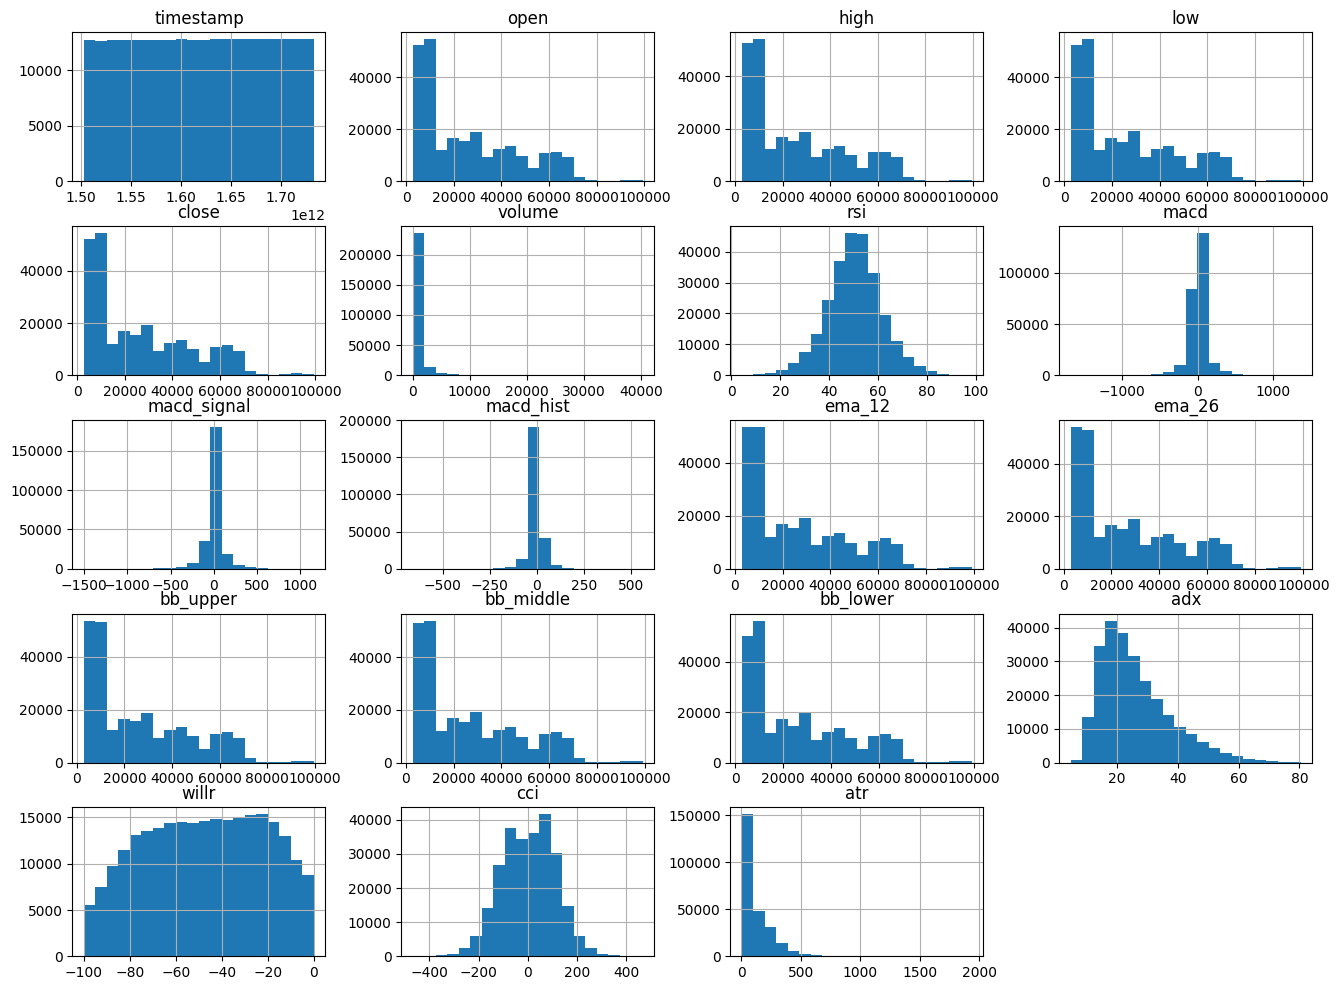

In [80]:
# histogram plot
df_test = df_15[['timestamp', 'open', 'high', 'low', 'close', 'volume', 'timeframe',
       'rsi', 'macd', 'macd_signal', 'macd_hist', 'ema_12', 'ema_26',
       'bb_upper', 'bb_middle', 'bb_lower', 'adx', 'willr', 'cci', 'atr']]
df_test.hist(bins=20, grid=True, figsize=(16,12))
plt.show()

- Not appropriate to add seaonsal data to BTC timeseries data
- Because we are looking at point where divergence occur, total data analysis is not required